In [1]:
import matplotlib.colors as mcolors
import matplotlib.animation as ma
import matplotlib.pyplot as plt
from itertools import product
from typing import List
import pandas as pd
import numpy as np
import numba as nb
import imageio
import sys
import os
import shutil

randomSeed = 10

if "ipykernel_launcher.py" in sys.argv[0]:
    from tqdm.notebook import tqdm
else:
    from tqdm import tqdm

new_cmap = mcolors.LinearSegmentedColormap.from_list(
    "new", plt.cm.jet(np.linspace(0, 1, 256)) * 0.85, N=256
)

@nb.njit
def colors_idx(phaseTheta):
    return np.floor(256 - phaseTheta / (2 * np.pi) * 256).astype(np.int32)

import seaborn as sns

sns.set_theme(
    style="ticks", 
    font_scale=1.1, rc={
    'figure.figsize': (6, 5),
    'axes.facecolor': 'white',
    'figure.facecolor': 'white',
    'grid.color': '#dddddd',
    'grid.linewidth': 0.5,
    "lines.linewidth": 1.5,
    'text.color': '#000000',
    'figure.titleweight': "bold",
    'xtick.color': '#000000',
    'ytick.color': '#000000'
})

plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'
if os.path.exists("/opt/conda/bin/ffmpeg"):
    plt.rcParams['animation.ffmpeg_path'] = "/opt/conda/bin/ffmpeg"
else:
    plt.rcParams['animation.ffmpeg_path'] = "D:/Programs/ffmpeg/bin/ffmpeg.exe"

colors = ["#5C49AC", "#1F9BCE", "#00B5CA", "#BED45F", "#F9E03B"]
cmap = mcolors.LinearSegmentedColormap.from_list("my_colormap", colors)
cmap_r = mcolors.LinearSegmentedColormap.from_list("my_colormap", colors[::-1])

from main import *

In [7]:
J = 0.1
agnetsCount = 500
Fs = np.linspace(0, 5, 30)
Ks = np.sort(np.concatenate([np.linspace(-1, 1, 30), [0]]))
# Ks = np.linspace(-1, 1, 30)
TNum = 500

# targetPath = f"./data/u1wDt0.01LastStateJ{J}.h5"
targetPath = f"./data/u1wLastStateJ{J}.h5"

totalPositionX = pd.read_hdf(targetPath, key="positionXs")
totalPhaseTheta = pd.read_hdf(targetPath, key="phaseThetas")
# pointXs = pd.read_hdf(targetPath, key="pointXs")
# pointThetas = pd.read_hdf(targetPath, key="pointThetas")

modelNums = totalPositionX.shape[0] // agnetsCount

totalPositionX = totalPositionX.values.reshape(modelNums, agnetsCount, 2)
totalPhaseTheta = totalPhaseTheta.values.reshape(modelNums, agnetsCount)
# totalPointX = pointXs.values.reshape(modelNums, TNum, 2)
# totalPointTheta = pointThetas.values.reshape(modelNums, TNum)

idx = 0
positionXs = dict()
phaseThetas = dict()

models = [
    MobileDrive(agentsNum=500, K=K, J=J, F=F, dt=0.02) 
    for F in Fs
    for K in Ks
]
for model in tqdm(models):
    
    model.positionX = totalPositionX[idx]
    model.phaseTheta = totalPhaseTheta[idx]
    model.counts = 9990
    model.update_temp()
    t = (model.counts) * model.dt
    model.drivePosition = np.array([
        model.druveRadiusR * np.cos(model.driveAngularVelocityW * t),
        model.druveRadiusR * np.sin(model.driveAngularVelocityW * t)
    ])
    # model.temp["pointX"] = totalPointX[idx]
    # model.temp["pointTheta"] = totalPointTheta[idx]
    idx += 1

del totalPositionX, totalPhaseTheta, # totalPointX, totalPointTheta

  0%|          | 0/930 [00:00<?, ?it/s]

In [3]:
maps4 = pd.DataFrame(index=Fs, columns=Ks, dtype=np.float64)
for model in tqdm(models):
    maps4.loc[model.F, model.K] = StateAnalysis.calc_order_parameter_Vp(model)

maps1 = pd.DataFrame(index=Fs, columns=Ks, dtype=np.float64)
for model in models:
    maps1.loc[model.F, model.K] = StateAnalysis.calc_order_parameter_R(model)

maps2 = pd.DataFrame(index=Fs, columns=Ks, dtype=np.float64)
for model in tqdm(models):
    maps2.loc[model.F, model.K] = StateAnalysis.calc_order_parameter_Ptr(model)

maps3 = pd.DataFrame(index=Fs, columns=Ks, dtype=np.float64)
for model in models:
    maps3.loc[model.F, model.K] = StateAnalysis.calc_order_parameter_S(model)

  0%|          | 0/930 [00:00<?, ?it/s]

  0%|          | 0/930 [00:00<?, ?it/s]

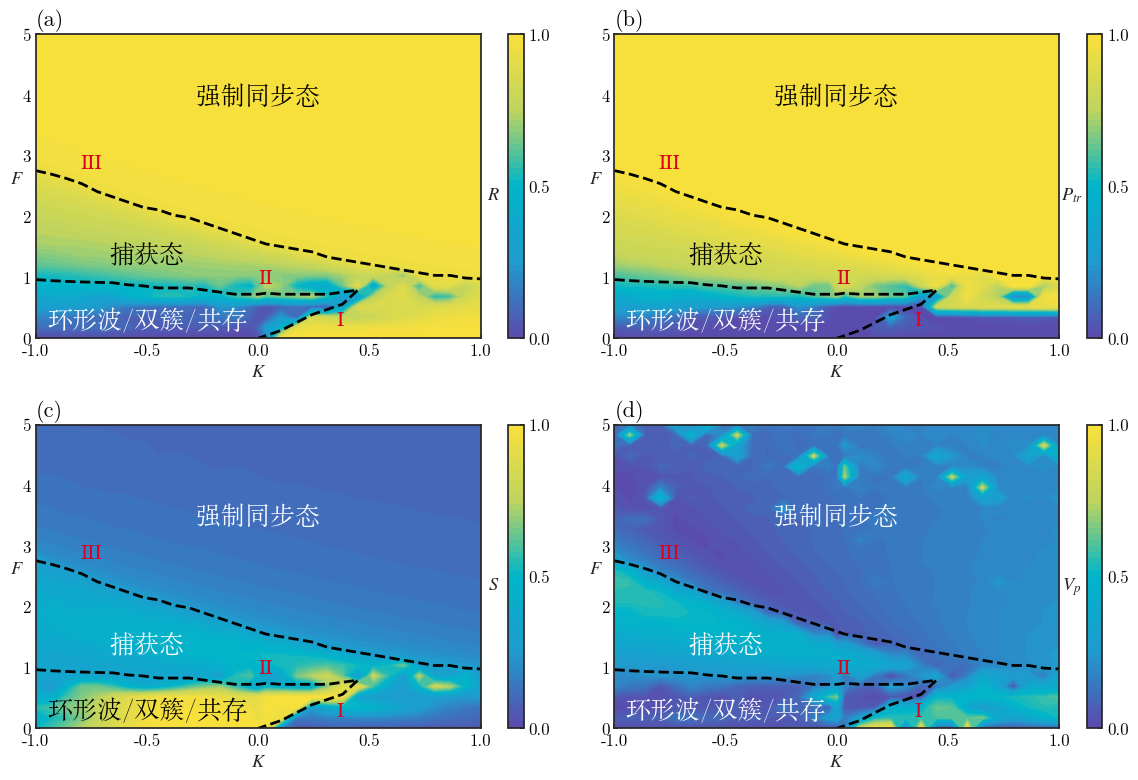

In [14]:
# For J=1
# get line1
Flocs = []
maps4Thres = 0.95
for K in Ks:
    reverseF = maps1[K][::-1]
    selectedIdxs = reverseF[(reverseF < maps4Thres) & (reverseF.shift() >= maps4Thres)].index
    if len(selectedIdxs) > 0:
        locF = selectedIdxs[0]
    Flocs.append(locF)
line1F = pd.Series(Flocs, index=Ks).rolling(4, center=True, min_periods=1).mean()
# get line2
Flocs = []
maps1Thres = 0.55
for K in Ks:
    Fvalues = maps1[K][::-1]
    selectedIdxs = Fvalues[Fvalues < maps1Thres].index
    if len(selectedIdxs) > 0:
        locF = selectedIdxs[0]
    Flocs.append(locF)
line2F = pd.Series(Flocs, index=Ks).rolling(10, center=True, min_periods=1).mean()
line2F = line2F.iloc[:23]
# get line3
Flocs = []
maps1Thres = 0.75
for K in Ks:
    Fvalues = maps1[K]
    selectedIdxs = Fvalues[Fvalues < maps1Thres].index
    if len(selectedIdxs) > 0:
        locF = selectedIdxs[0]
    Flocs.append(locF)
line3F = pd.Series(Flocs, index=Ks).rolling(4, center=True, min_periods=1).mean()
line3F = line3F.iloc[:22]
line2F = pd.concat([line2F, line3F[::-1]]).iloc[:-15]


import matplotlib.font_manager as fm
# plt.rcParams['font.family'] = "Times New Roman"
# plt.rcParams['font.sans-serif'] = ['SimHei']
fontpath = 'FandolSong-Regular.otf'
font = fm.FontProperties(fname=fontpath)
sns.set_theme(
    font=font.get_name(),
    style="ticks", 
    font_scale=1.1, rc={
    'figure.figsize': (6, 5),
    'axes.facecolor': 'white',
    'figure.facecolor': 'white',
    'grid.color': '#dddddd',
    'grid.linewidth': 0.5,
    "lines.linewidth": 1.5,
    'text.color': '#000000',
    'figure.titleweight': "bold",
    'xtick.color': '#000000',
    'ytick.color': '#000000'
})
plt.rcParams['axes.unicode_minus'] = False
fig, axs = plt.subplots(2, 2, figsize=(12, 8))
ax1, ax2, ax3, ax4 = axs.flatten()
# plt.rcParams['mathtext.fontset'] = 'stix'
# plt.rcParams['font.family'] = 'STIXGeneral'


levels = 50

cf1 = ax1.contourf(
    maps1.columns.values, maps1.index.values, 
    maps1.values, levels=levels, vmin=0, vmax=1,
    cmap=cmap, alpha=1
)
ax1.set_xticks([-1, -0.5, 0, 0.5, 1])
ax1.grid(False)
ax1.set_title("(a)", fontweight="bold", loc="left", fontsize=16)
cbar1 = plt.colorbar(cf1, ax=ax1, ticks=[0, 0.5, 1])
cbar1.ax.tick_params(direction='in', length=3)
cbar1.set_label(r"$R$", fontweight="bold", rotation=0)
cbar1.ax.yaxis.set_label_coords(-1, 0.5)
ax1.plot(line1F, color='black', linestyle="--", lw=2)
ax1.plot(line2F, color='black', linestyle="--", lw=2)
ax1.text(0, 4, "强制同步态", fontsize=18, color="black", ha="center", va="center")
ax1.text(-0.5, 1.4, "捕获态", fontsize=18, color="black", ha="center", va="center")
ax1.text(-0.5, 0.3, "环形波/双簇/共存", fontsize=18, color="white", ha="center", va="center")

stdMaps2 = maps2.copy()
stdMaps2.iloc[0, 0] = 0
stdMaps2.iloc[0, 1] = 1
cf2 = ax2.contourf(
    maps2.columns.values, maps2.index.values, 
    stdMaps2.values, levels=levels, vmin=0, vmax=1,
    cmap=cmap, alpha=1
)
ax2.contourf(
    maps2.columns.values, maps2.index.values, 
    maps2.values, levels=levels, vmin=0, vmax=1,
    cmap=cmap, alpha=1
)
ax2.set_xticks([-1, -0.5, 0, 0.5, 1])
ax2.grid(False)
ax2.set_title("(b)", fontweight="bold", loc="left", fontsize=16)
cbar2 = plt.colorbar(cf2, ax=ax2, ticks=[0, 0.5, 1])
cbar2.ax.tick_params(direction='in', length=3)
cbar2.set_label(r"$P_{tr}$", fontweight="bold", rotation=0)
cbar2.ax.yaxis.set_label_coords(-1, 0.5)
ax2.plot(line1F, color='black', linestyle="--", lw=2)
ax2.plot(line2F, color='black', linestyle="--", lw=2)
ax2.text(0, 4, "强制同步态", fontsize=18, color="black", ha="center", va="center")
ax2.text(-0.5, 1.4, "捕获态", fontsize=18, color="black", ha="center", va="center")
ax2.text(-0.5, 0.3, "环形波/双簇/共存", fontsize=18, color="white", ha="center", va="center")

stdMaps3 = maps3.copy()
stdMaps3.iloc[0, 0] = 0
stdMaps3.iloc[0, 1] = 1
cf3 = ax3.contourf(
    maps3.columns.values, maps3.index.values, 
    stdMaps3.values, levels=levels, vmin=0, vmax=1,
    cmap=cmap, alpha=1
)
ax3.contourf(
    maps3.columns.values, maps3.index.values, 
    maps3.values, levels=levels, vmin=0, vmax=1,
    cmap=cmap, alpha=1
)
ax3.set_xticks([-1, -0.5, 0, 0.5, 1])
ax3.grid(False)
ax3.set_title("(c)", fontweight="bold", loc="left", fontsize=16)
cbar3 = plt.colorbar(cf3, ax=ax3, ticks=[0, 0.5, 1])
cbar3.ax.set_ylim(0, 1)
cbar3.ax.tick_params(direction='in', length=3)
cbar3.set_label(r"$S$", fontweight="bold", rotation=0)
cbar3.ax.yaxis.set_label_coords(-1, 0.5)
ax3.plot(line1F, color='black', linestyle="--", lw=2)
ax3.plot(line2F, color='black', linestyle="--", lw=2)
ax3.text(0, 3.5, "强制同步态", fontsize=18, color="white", ha="center", va="center")
ax3.text(-0.5, 1.4, "捕获态", fontsize=18, color="white", ha="center", va="center")
ax3.text(-0.5, 0.3, "环形波/双簇/共存", fontsize=18, color="black", ha="center", va="center")

stdMaps4 = maps4.copy()
stdMaps4.iloc[0, 0] = 0
stdMaps4.iloc[0, 1] = 1
cf4 = ax4.contourf(
    maps3.columns.values, maps3.index.values, 
    stdMaps4.values, levels=levels, vmin=0, vmax=1,
    cmap=cmap, alpha=1, zorder=0
)
dealtMaps4 = maps4.copy()
thres = 0.3
# dealtMaps4.iloc[10:] = dealtMaps4.iloc[10:].mask(dealtMaps4 > thres, thres)
ax4.contourf(
    maps4.columns.values, maps4.index.values, 
    dealtMaps4.values, levels=levels, vmin=0, vmax=1,
    cmap=cmap, alpha=1, # zorder=10
)
ax4.set_xticks([-1, -0.5, 0, 0.5, 1])
ax4.grid(False)
ax4.set_title("(d)", fontweight="bold", loc="left", fontsize=16)
cbar4 = plt.colorbar(cf4, ax=ax4, ticks=[0, 0.5, 1])
cbar4.ax.tick_params(direction='in', length=3)
cbar4.set_label(r"$V_p$", fontweight="bold", rotation=0, loc="center")
cbar4.ax.yaxis.set_label_coords(-1, 0.5)
ax4.plot(line1F, color='black', linestyle="--", lw=2)
ax4.plot(line2F, color='black', linestyle="--", lw=2)
ax4.text(0, 3.5, "强制同步态", fontsize=18, color="white", ha="center", va="center")
ax4.text(-0.5, 1.4, "捕获态", fontsize=18, color="white", ha="center", va="center")
ax4.text(-0.5, 0.3, "环形波/双簇/共存", fontsize=18, color="white", ha="center", va="center")

for ax in axs.flatten():
    ax.tick_params(direction='in', length=3)
    ax.set_ylabel(r"$F$", fontweight="bold", rotation=0)
    ax.set_xlabel(r"$K$", fontweight="bold")
    # 标注I，II，III，字体用Times New Roman
    ax.text(0.35, 0.2, 'I', fontsize=16, fontname='Times New Roman', color='#DE0022')
    ax.text(0.0, 0.9, 'II', fontsize=16, fontname='Times New Roman', color='#DE0022')
    ax.text(-0.8, 2.8, 'III', fontsize=16, fontname='Times New Roman', color='#DE0022')
    # ax.text(0.0, 0.9, 'I', fontsize=16, fontname='Times New Roman', color='#DE0022')
    # ax.text(-0.8, 2.8, 'II', fontsize=16, fontname='Times New Roman', color='#DE0022')

plt.tight_layout()
# plt.savefig(f"./figs/formal/eps/orderParameterMapJ{J}_2lines.eps", bbox_inches="tight")
plt.savefig(f"./figs/orderParameterMapJ{J}_3lines.png", bbox_inches="tight", dpi=200)

In [8]:
class StateAnalysis:
    def __init__(self, model: MobileDrive, lookIndex: int = -1, showTqdm: bool = False):
        self.model = model
        self.lookIndex = lookIndex
        self.showTqdm = showTqdm
        
        targetPath = f"{self.model.savePath}/{self.model}.h5"
        totalPositionX = pd.read_hdf(targetPath, key="positionX")
        totalPhaseTheta = pd.read_hdf(targetPath, key="phaseTheta")
        totalPointX = pd.read_hdf(targetPath, key="pointX")
        totalPointTheta = pd.read_hdf(targetPath, key="pointTheta")
        
        TNum = totalPositionX.shape[0] // self.model.agentsNum
        self.TNum = TNum
        self.tRange = np.arange(0, (TNum - 1) * model.shotsnaps, model.shotsnaps) * self.model.dt
        self.totalPositionX = totalPositionX.values.reshape(TNum, self.model.agentsNum, 2)
        self.totalPhaseTheta = totalPhaseTheta.values.reshape(TNum, self.model.agentsNum)
        self.totalPointX = totalPointX.values.reshape(TNum, self.model.agentsNum, 2)
        self.totalPointTheta = totalPointTheta.values.reshape(TNum, self.model.agentsNum)
        self.totalDrivePosition = np.array([
            model.druveRadiusR * np.cos(model.driveAngularVelocityW * self.tRange),
            model.druveRadiusR * np.sin(model.driveAngularVelocityW * self.tRange)
        ]).transpose(1, 0)
        self.totalDrivePhaseTheta = np.mod(model.driveThateVelocityOmega * self.tRange, 2 * np.pi)

        self.centersValue = None
        self.classesValue = None

        if self.showTqdm:
            self.iterObject = tqdm(range(1, self.totalPhaseTheta.shape[0]))
        else:
            self.iterObject = range(1, self.totalPhaseTheta.shape[0])
            
    @staticmethod
    def calc_order_parameter_R(model: MobileDrive) -> float:
        return np.abs(np.sum(np.exp(1j * model.phaseTheta))) / model.agentsNum
    
    @staticmethod
    def calc_order_parameter_S(model: MobileDrive) -> float:
        phi = np.arctan2(model.positionX[:, 1], model.positionX[:, 0])
        Sadd = np.abs(np.sum(np.exp(1j * (phi + model.phaseTheta)))) / model.agentsNum
        Ssub = np.abs(np.sum(np.exp(1j * (phi - model.phaseTheta)))) / model.agentsNum
        return np.max([Sadd, Ssub])

    @staticmethod
    def calc_order_parameter_Vp(model: MobileDrive) -> float:
        self = model
        pointX, pointTheta = self._calc_point(
            self.positionX, self.phaseTheta,
            self.velocity, self.omega,
            self.Iatt, self.Irep,
            self.Fatt, self.Frep,
            self.H, self.G, self.P,
            self.K, self.dt, 
        )
        phi = np.arctan2(pointX[:, 1], pointX[:, 0])
        return np.abs(np.sum(np.exp(1j * phi))) / model.agentsNum
    
    @staticmethod
    def calc_order_parameter_Ptr(model: MobileDrive) -> float:
        self = model
        pointX, pointTheta = self._calc_point(
            self.positionX, self.phaseTheta,
            self.velocity, self.omega,
            self.Iatt, self.Irep,
            self.Fatt, self.Frep,
            self.H, self.G, self.P,
            self.K, self.dt, 
        )
        Ntr = np.abs(pointTheta - model.driveThateVelocityOmega) < 0.2 / model.dt * 0.1
        return Ntr.sum() / model.agentsNum
    
    @staticmethod
    def plot_last_state(model: MobileDrive, ax: plt.Axes, withColorBar: bool =True, s: float = 50, driveS: float = 100):
        t = model.counts * model.dt
        model.drivePosition = np.array([
            np.cos(model.driveThateVelocityOmega * t) * model.druveRadiusR,
            np.sin(model.driveThateVelocityOmega * t) * model.druveRadiusR
        ])
        ax.scatter(model.drivePosition[0], model.drivePosition[1], color="white", s=driveS, marker='o', edgecolors='k', zorder=10)
        sc = ax.scatter(model.positionX[:, 0], model.positionX[:, 1], s=s,
                    c=model.phaseTheta, cmap=new_cmap, alpha=0.8, vmin=0, vmax=2*np.pi)
        driveCircle = plt.Circle((0, 0), model.druveRadiusR, color='black', fill=False, lw=2, linestyle='--')
        ax.add_artist(driveCircle)
        if withColorBar:
            cbar = plt.colorbar(sc, ticks=[0, np.pi, 2*np.pi], ax=ax)
            cbar.ax.set_ylim(0, 2*np.pi)
            cbar.ax.set_yticklabels(['$0$', '$\pi$', '$2\pi$'])

In [9]:
maps4 = pd.DataFrame(index=Fs, columns=Ks, dtype=np.float64)
for model in tqdm(models):
    maps4.loc[model.F, model.K] = StateAnalysis.calc_order_parameter_Vp(model)

maps1 = pd.DataFrame(index=Fs, columns=Ks, dtype=np.float64)
for model in models:
    maps1.loc[model.F, model.K] = StateAnalysis.calc_order_parameter_R(model)

maps2 = pd.DataFrame(index=Fs, columns=Ks, dtype=np.float64)
for model in tqdm(models):
    maps2.loc[model.F, model.K] = StateAnalysis.calc_order_parameter_Ptr(model)

maps3 = pd.DataFrame(index=Fs, columns=Ks, dtype=np.float64)
for model in models:
    maps3.loc[model.F, model.K] = StateAnalysis.calc_order_parameter_S(model)

  0%|          | 0/930 [00:00<?, ?it/s]

  0%|          | 0/930 [00:00<?, ?it/s]

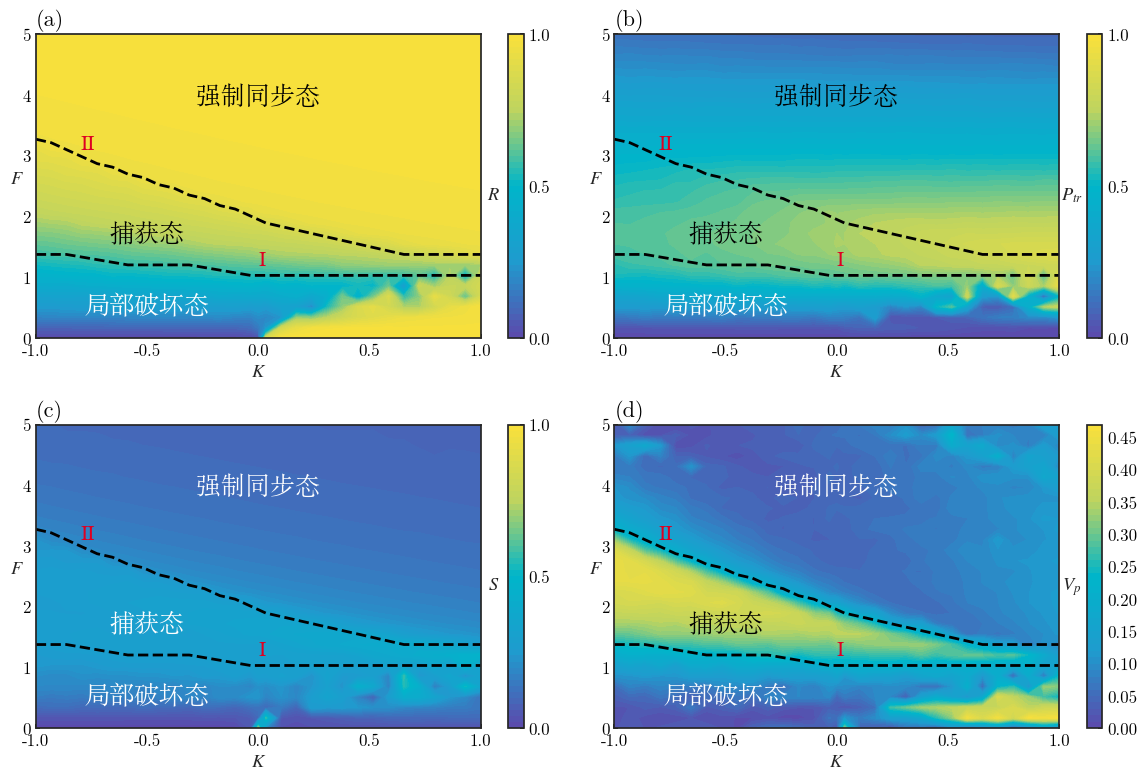

In [12]:
# For J=0.1
# get line1
Flocs = []
maps4Thres = 0.25
for K in Ks:
    selectedIdxs = maps4[(maps4[K] < maps4Thres) & (maps4[K].shift() >= maps4Thres) & (Fs > 1)].index
    if len(selectedIdxs) > 0:
        locF = selectedIdxs[0]
    Flocs.append(locF)
line1F = pd.Series(Flocs, index=Ks).rolling(3, center=True, min_periods=1).mean()
# get line2
Flocs = []
maps1Thres = 0.6
for K in Ks:
    reverseF = maps1[K][::-1]
    selectedIdxs = reverseF[(reverseF < maps1Thres) & (reverseF.shift() >= maps1Thres)].index
    if len(selectedIdxs) > 0:
        locF = selectedIdxs[0]
    Flocs.append(locF)
line2F = pd.Series(Flocs, index=Ks).rolling(4, center=True, min_periods=1).mean()
# get line3
Flocs = []
maps1Thres = 0.6
for K in Ks:
    Fvalues = maps1[K]
    selectedIdxs = Fvalues[Fvalues < maps1Thres].index
    if len(selectedIdxs) > 0:
        locF = selectedIdxs[0]
    Flocs.append(locF)
# line3F = pd.Series(Flocs, index=Ks).rolling(6, center=True, min_periods=1).mean()

import matplotlib.font_manager as fm
# plt.rcParams['font.family'] = "Times New Roman"
# plt.rcParams['font.sans-serif'] = ['SimHei']
fontpath = 'FandolSong-Regular.otf'
font = fm.FontProperties(fname=fontpath)
sns.set_theme(
    font=font.get_name(),
    style="ticks", 
    font_scale=1.1, rc={
    'figure.figsize': (6, 5),
    'axes.facecolor': 'white',
    'figure.facecolor': 'white',
    'grid.color': '#dddddd',
    'grid.linewidth': 0.5,
    "lines.linewidth": 1.5,
    'text.color': '#000000',
    'figure.titleweight': "bold",
    'xtick.color': '#000000',
    'ytick.color': '#000000'
})
plt.rcParams['axes.unicode_minus'] = False
fig, axs = plt.subplots(2, 2, figsize=(12, 8))
ax1, ax2, ax3, ax4 = axs.flatten()
# plt.rcParams['mathtext.fontset'] = 'stix'
# plt.rcParams['font.family'] = 'STIXGeneral'


levels = 50

cf1 = ax1.contourf(
    maps1.columns.values, maps1.index.values, 
    maps1.values, levels=levels, vmin=0, vmax=1,
    cmap=cmap, alpha=1
)
ax1.set_xticks([-1, -0.5, 0, 0.5, 1])
ax1.grid(False)
ax1.set_title("(a)", fontweight="bold", loc="left", fontsize=16)
cbar1 = plt.colorbar(cf1, ax=ax1, ticks=[0, 0.5, 1])
cbar1.ax.tick_params(direction='in', length=3)
cbar1.set_label(r"$R$", fontweight="bold", rotation=0)
cbar1.ax.yaxis.set_label_coords(-1, 0.5)
ax1.plot(line1F, color='black', linestyle="--", lw=2)
ax1.plot(line2F, color='black', linestyle="--", lw=2)
# ax1.plot(line3F, color='black', linestyle="--", lw=2)
ax1.text(0, 4, "强制同步态", fontsize=18, color="black", ha="center", va="center")
ax1.text(-0.5, 1.75, "捕获态", fontsize=18, color="black", ha="center", va="center")
# ax1.text(0.7, 0.3, "Tide State", fontsize=14, color="black", ha="center", va="center")
ax1.text(-0.5, 0.55, "局部破坏态", fontsize=18, color="white", ha="center", va="center")

stdMaps2 = maps2.copy()
stdMaps2.iloc[0, 0] = 0
stdMaps2.iloc[0, 1] = 1
cf2 = ax2.contourf(
    maps2.columns.values, maps2.index.values, 
    stdMaps2.values, levels=levels, vmin=0, vmax=1,
    cmap=cmap, alpha=1
)
ax2.contourf(
    maps2.columns.values, maps2.index.values, 
    maps2.values, levels=levels, vmin=0, vmax=1,
    cmap=cmap, alpha=1
)
ax2.set_xticks([-1, -0.5, 0, 0.5, 1])
ax2.grid(False)
ax2.set_title("(b)", fontweight="bold", loc="left", fontsize=16)
cbar2 = plt.colorbar(cf2, ax=ax2, ticks=[0, 0.5, 1])
cbar2.ax.tick_params(direction='in', length=3)
cbar2.set_label(r"$P_{tr}$", fontweight="bold", rotation=0)
cbar2.ax.yaxis.set_label_coords(-1, 0.5)
ax2.plot(line1F, color='black', linestyle="--", lw=2)
ax2.plot(line2F, color='black', linestyle="--", lw=2)
# ax2.plot(line3F, color='black', linestyle="--", lw=2)
ax2.text(0, 4, "强制同步态", fontsize=18, color="black", ha="center", va="center")
ax2.text(-0.5, 1.75, "捕获态", fontsize=18, color="black", ha="center", va="center")
# ax2.text(0.7, 0.3, "Tide State", fontsize=14.5, color="white", ha="center", va="center")
ax2.text(-0.5, 0.55, "局部破坏态", fontsize=18, color="white", ha="center", va="center")

stdMaps3 = maps3.copy()
stdMaps3.iloc[0, 0] = 0
stdMaps3.iloc[0, 1] = 1
cf3 = ax3.contourf(
    maps3.columns.values, maps3.index.values, 
    stdMaps3.values, levels=levels, vmin=0, vmax=1,
    cmap=cmap, alpha=1
)
ax3.contourf(
    maps3.columns.values, maps3.index.values, 
    maps3.values, levels=levels, vmin=0, vmax=1,
    cmap=cmap, alpha=1
)
ax3.set_xticks([-1, -0.5, 0, 0.5, 1])
ax3.grid(False)
ax3.set_title("(c)", fontweight="bold", loc="left", fontsize=16)
cbar3 = plt.colorbar(cf3, ax=ax3, ticks=[0, 0.5, 1])
cbar3.ax.set_ylim(0, 1)
cbar3.ax.tick_params(direction='in', length=3)
cbar3.set_label(r"$S$", fontweight="bold", rotation=0)
cbar3.ax.yaxis.set_label_coords(-1, 0.5)
ax3.plot(line1F, color='black', linestyle="--", lw=2)
ax3.plot(line2F, color='black', linestyle="--", lw=2)
# ax3.plot(line3F, color='black', linestyle="--", lw=2)
ax3.text(0, 4, "强制同步态", fontsize=18, color="white", ha="center", va="center")
ax3.text(-0.5, 1.75, "捕获态", fontsize=18, color="white", ha="center", va="center")
# ax3.text(0.7, 0.3, "Tide State", fontsize=14.5, color="white", ha="center", va="center")
ax3.text(-0.5, 0.55, "局部破坏态", fontsize=18, color="white", ha="center", va="center")

cf4 = ax4.contourf(
    maps4.columns.values, maps4.index.values, 
    maps4.values, levels=levels, # vmin=0, vmax=1,
    cmap=cmap, alpha=1
)
ax4.set_xticks([-1, -0.5, 0, 0.5, 1])
ax4.grid(False)
ax4.set_title("(d)", fontweight="bold", loc="left", fontsize=16)
cbar4 = plt.colorbar(cf4, ax=ax4)
cbar4.ax.tick_params(direction='in', length=3)
cbar4.set_label(r"$V_p$", fontweight="bold", rotation=0, loc="center")
cbar4.ax.yaxis.set_label_coords(-1, 0.5)
ax4.plot(line1F, color='black', linestyle="--", lw=2)
ax4.plot(line2F, color='black', linestyle="--", lw=2)
# ax4.plot(line3F, color='black', linestyle="--", lw=2)
ax4.text(0, 4, "强制同步态", fontsize=18, color="white", ha="center", va="center")
ax4.text(-0.5, 1.75, "捕获态", fontsize=18, color="black", ha="center", va="center")
# ax4.text(0.7, 0.3, "Tide State", fontsize=14, color="black", ha="center", va="center")
ax4.text(-0.5, 0.55, "局部破坏态", fontsize=18, color="white", ha="center", va="center")

for ax in axs.flatten():
    ax.tick_params(direction='in', length=3)
    ax.set_ylabel(r"$F$", fontweight="bold", rotation=0)
    ax.set_xlabel(r"$K$", fontweight="bold")
    # ax.text(0.35, 0.3, 'I', fontsize=16, fontname='Times New Roman', color='#DE0022')
    ax.text(0.0, 1.2, 'I', fontsize=16, fontname='Times New Roman', color='#DE0022')
    ax.text(-0.8, 3.1, 'II', fontsize=16, fontname='Times New Roman', color='#DE0022')

plt.tight_layout()
# plt.savefig(f"./figs/formal/eps/orderParameterMapJ{J}.eps", bbox_inches="tight")
plt.savefig(f"./figs/orderParameterMapJ{J}.png", bbox_inches="tight", dpi=200)